# UJIIndoorLoc Response EDA and Classification - Part 2

In the [previous notebook](#UJIIndoorLoc-preprocess.ipynb), we performed various transformations on the independent variables of the raw UJIIndoorLoc dataset to prepare it for the machine learning. 

In this notebook, first, I focus on our response variables including building ID, floor ID, latitiude and longitude. Understanding the class imbalance in classification responses buildingID and floorID is important for training our machine learning models. Similarly, I analyze the distributions of our regression response variables latitude and longitude and their relationship with the building ID and floor ID. Second, I formulate the localization problem for the machine learning. Finally, I begin constructing machine learning framework first by focusing on regression without Floor and Building information. In future notebooks, I will model and evaluate cascade machine learning frameworks that perform building and floor classification before applying building and floor-optimized regression models.

## Table of Contents

1. [Setup](#setup)

2. [Response EDA](#response-eda)

3. [Problem Formulation](#problem-formulation)

4. [Multi-Variable Multivariate Regression](#regression)
                
6. [Conclusion](#conclusion)

<p><a name="setup"></a></p>

## 1. Setup

In [15]:
# Data Collection and Transformations
import numpy as np
import pandas as pd
import datetime as dt
import time
import pickle
#from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from itertools import cycle

# Statistical Testing
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Regression 
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
#import xgboost as xgb
#from xgboost.sklearn import XGBRegressor

# Class imbalance 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Plotting 
from mlxtend.plotting import plot_learning_curves
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams['figure.figsize'] = [10,8]
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Loading the transformed data from our previous notebook.

In [16]:
X_pca_crossval = pd.read_csv("data/X_pca_crossval.csv",index_col=0)
y_crossval = pd.read_csv("data/y_crossval.csv",index_col=0)

X_pca_holdout = pd.read_csv("data/X_pca_holdout.csv",index_col=0)
y_holdout = pd.read_csv("data/y_holdout.csv",index_col=0)

X_raw_crossval = pd.read_csv("data/X_raw_crossval.csv",index_col=0)
X_raw_holdout = pd.read_csv("data/X_raw_holdout.csv",index_col=0)

X_pca_crossval.shape,y_crossval.shape,X_pca_holdout.shape,y_holdout.shape

((17874, 150), (17874, 6), (1987, 150), (1987, 6))

In [17]:
X_raw_crossval.fillna(value=100,inplace=True)
X_raw_holdout.fillna(value=100,inplace=True)

<p><a name="building-eda"></a></p>

In [20]:
y_crossval.head()

ImportError: cannot import name 'is_url'

       LONGITUDE      LATITUDE  FLOOR  BUILDINGID  SPACEID  RELATIVEPOSITION
14651 -7367.4588  4.864842e+06      1           2      117                 2
16771 -7594.2641  4.864982e+06      3           0      108                 2
17601 -7596.2032  4.864982e+06      3           0      107                 2
6651  -7322.5876  4.864821e+06      0           2      103                 2
86    -7384.2113  4.864776e+06      3           2      222                 2

In the next few sections, we explore the characteristics of the different response variables.

<p><a name="response-eda"></a></p>

## 2. Response EDA

### 2.1 Building EDA

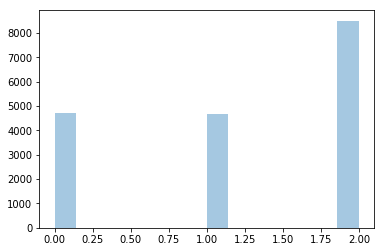

In [21]:
sns.distplot(y_crossval[['BUILDINGID']],kde=False)

*Observations*:

1. In our training samples, building 2 has the clear majority with it's count being slightly lower than the sum of building 0 and building 1.

2. Building 0 and building 1 have roughly the same representation in the training data.

Clearly, there is an imbalance among the groups.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


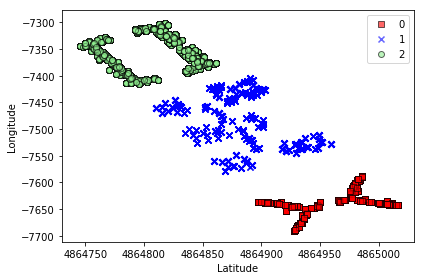

In [22]:
markers = ('s', 'x', 'o', '^', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
cmap = ListedColormap(colors[:len(np.unique(y_crossval['BUILDINGID']))])

for idx, cl in enumerate(np.unique(y_crossval['BUILDINGID'])):
        plt.scatter(x=y_crossval.loc[y_crossval.BUILDINGID== cl]['LATITUDE'], 
                    y=y_crossval.loc[y_crossval.BUILDINGID== cl]['LONGITUDE'],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend(loc='upper right')
plt.tight_layout()

The above plot illustrates the locations of the buildings in the campus.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


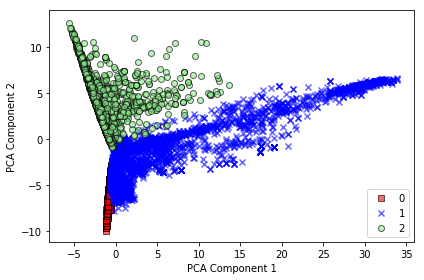

In [23]:
markers = ('s', 'x', 'o', '^', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
cmap = ListedColormap(colors[:len(np.unique(y_crossval['BUILDINGID']))])

for idx, cl in enumerate(np.unique(y_crossval['BUILDINGID'])):
        plt.scatter(x=X_pca_crossval.loc[y_crossval.BUILDINGID== cl].iloc[:,0], 
                    y=X_pca_crossval.loc[y_crossval.BUILDINGID== cl].iloc[:,1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(loc='lower right')
plt.tight_layout()

The above plot illustrates how the buildingID are distributed across the top two PCA dimensions. Later, I explore the machine learning approaches for the building classification.

Remember PCA is an *unsupervised learning* technique for dimensionality reduction. So, it is quite possible the two top PCA components might not have explained our response variable well.

<p><a name = "floor-eda"></a></p>

### 2.2 Floor EDA

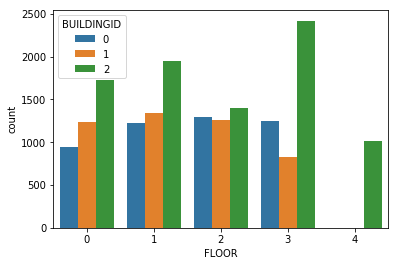

In [24]:
sns.countplot(x="FLOOR", hue="BUILDINGID", data=y_crossval,orient="v")

*Observations*:
    
1. Buildings 0 and 1 have 4 floors whereas Building 2 has 5 floors.

2. Expectedly, the samples from Building 2 are consistently the highest across all the floors.

<p><a name="Problem Formulation"></p>

<p><a name="problem-formulation"></a></p>

## 3. Problem Formulation

### 3.1 Error Metric

The overall goal of this project is to build models for accurate indoor localization. The mean positioning error expressed as the mean Euclidean distance between the real and estimated locations. **However, in multi-building, multi-floor environments as in our problem, just the positioning error due to Euclidean distance is not enough.** Wrong floor and wrong building classification are not desirable as the actual movement from the predicted location to the actual location might involve great displacement.

Therefore, we include penalty terms to the mean error equation to penalize failures in floor and building classification. This was introduced in the [2015 EvAAL-ETRI competition](http://content.iospress.com/articles/journal-of-ambient-intelligence-and-smart-environments/ais421). The cost function can be expressed as follows:

$positioning\_error(actual,predicted)= euclidean\_distance(actual,predicted) + penalty_{floor}*fail_{floor} + penalty_{building}*fail_{building}$

where $fail_{floor}$ and $fail_{building}$ indicate if the floor and building are incorrectly identified, $penalty_{floor}$ and $penalty_{building}$ are the penalty values applied for wrongful classification of floor and building respectively. The penalty values were set to 4 and 50 respectively in the third track of the competition ([Source](http://ieeexplore.ieee.org/document/7743679/)). Expectedly, the penalty for building classification failure is higher than that of floor classification failure. In this project, I utilize the same penalty term values for the error metric.

### 3.2 Machine Learning Methodology

Because of the added penalty terms, we cannot simply perform regression for the Latitude and Longitude. Separate models might have to be trained per-floor and per-building. Hence, the building and floor need to be classified first.

However, I first analyze the regression variables in isolation without incorporating the buildingID and FloorID. The framework built will be used for comparison against the Cascade framework that incorporates the building and floor information.

<p> <a name = "regression"></a></p>

## 4. Multi-Variable Multivariate Regression

**The key concepts of building the regression framework include:**

1. *MultiOutputRegressor*: We have the response as a vector of 2-dimensions (Latitude and Longitude). Not every regression method in scikit-learn can handle this sort of problem. Most linear models provide this capability but for those that don't, a new class MultiOutputRegressor is available for parallelization of regressors for multivariate output.

2. *Linear Regression Models*: First, I will focus on Linear regression and its variants including Lasso, Kernel Ridge.

3. *Polynomial Features*: Consider Polynomial Features including quadratic and cubic for addressing non-linearities.

4. *Other Regression Models*: ExtraTreesRegressor, RandomForestRegressor, XGBoostRegressor

5. *Stacking*: Simple Average, XGBoost stacking as shown in this [Kaggle kernel](https://www.kaggle.com/eliotbarr/house-prices-advanced-regression-techniques/stacking-starter/run/598752).

In [25]:
X_train = np.array(X_pca_crossval)
y_train = y_crossval[['LATITUDE','LONGITUDE']]

X_test = np.array(X_pca_holdout)
y_test = y_holdout[['LATITUDE','LONGITUDE']]

X_train.shape,y_train.shape,X_test.shape,y_test.shape

((17874, 150), (17874, 2), (1987, 150), (1987, 2))

In [26]:
# Dictionary to store nested cross-validation scores
model_scores = {}

# Dictionary to store model and param grid mapping
model_param_grid = {}

In the next few sub-sections, we perform nested cross-validation on the different model families. In nested cross-validation, the inner fold performs the parameter tuning and the outer fold is used for the validation performance.

Before we begin the model assessment, let's write a function to simplify the nested cross-validation operation.

### 4.1 Nested Cross-Validation

In [27]:
def nested_crossval(reg_list,reg_labels, model_param_grid=model_param_grid, model_scores = model_scores,
                    X = X_train, y= y_train, label_extension = None):
    '''
    Inputs:
    reg_model        : List of Regression model instances
    reg_label        : List of Regression model labels
    model_param_grid : List of parameter grids
    X                : explanatory variables 
    y                : response variable array
    model_scores     : Dictionary to store nested cross-validation scores
    label_extension  : Extension to regression label in model_scores key
    
    Outputs:
    model_scores     : Updated dictionary of nested cross-validation scores
    '''

    
    for reg_model, reg_label in zip(reg_list, reg_labels):
    
        #print(param_grid)
    
        gs = (GridSearchCV(estimator=reg_model, 
                            param_grid=model_param_grid[reg_label], 
                            cv=2,
                            scoring = 'neg_mean_squared_error',
                            n_jobs = 1))
    
        scores = cross_val_score(estimator=gs,
                                 X=X,
                                 y=y,
                                 cv=5,
                                 scoring='neg_mean_squared_error')
        scores = np.sqrt(np.abs(scores))
        
        if label_extension:
            reg_label += '_' + label_extension
        
        print("RMSE: %0.2f (+/- %0.2f) [%s]"
              % (scores.mean(), scores.std(), reg_label))
        
        model_scores[reg_label] = scores
        
    
    return model_scores

### 4.2 Linear Models and Variants

In this sub-section, I analyze the performance of Linear Regression models and its regularization variants.

In [28]:
## Linear Models

# Ridge Regression
pipe_ridge = Pipeline([('scl', StandardScaler()),
            ('reg', Ridge(random_state=1))])

# Lasso
pipe_lasso = Pipeline([('scl', StandardScaler()),
            ('reg', Lasso(random_state=1))])

param_grid_lm= {
    'reg__alpha':[0.01,0.1,1,10],
}

reg_lm = [pipe_ridge,pipe_lasso]
reg_labels_lm = ['Ridge','Lasso']
model_param_grid['Ridge'] = param_grid_lm
model_param_grid['Lasso'] = param_grid_lm

model_scores = nested_crossval(reg_lm,reg_labels_lm)

RMSE: 25.25 (+/- 0.41) [Ridge]
RMSE: 25.26 (+/- 0.43) [Lasso]


In [29]:
model_scores

{'Ridge': array([25.43926941, 24.53596898, 25.780613  , 25.20794527, 25.30487622]),
 'Lasso': array([25.49069375, 24.50169635, 25.78675344, 25.24330896, 25.29979238])}

Interestingly, ridge regression and Lasso provide nearly the same performance but still very far from our baseline of 7.5m.

### 4.2 Polynomial Regression

In this sub-section, we analyze the non-linear variations of Regression by incorporating higher-order features into the Regression Analysis.

In [30]:
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X_train)

pipe_ridge_poly = Pipeline([('scl', StandardScaler()),
                            ('pca', PCA(n_components=100)),
                            ('reg', Ridge(random_state=1))])

# Lasso
pipe_lasso_poly = Pipeline([('scl', StandardScaler()),
                            ('pca', PCA(n_components=100)),
                            ('reg', Lasso(random_state=1))])

reg_lm_quad = [pipe_ridge_poly,pipe_lasso_poly]
reg_labels_lm_quad = ['Ridge_Quadratic','Lasso_Quadratic']
model_param_grid['Ridge_Quadratic'] = param_grid_lm
model_param_grid['Lasso_Quadratic'] = param_grid_lm

model_scores = nested_crossval(reg_lm_quad,reg_labels_lm_quad, X= X_quad)

KeyboardInterrupt: 

In [ ]:
# First, let's save our data into a file
f = open("model_scores_lm.pckl", "wb")
pickle.dump(model_scores,f)

In [ ]:
pkl_file = open('model_scores_lm.pckl', 'rb')

model_scores = pickle.load(pkl_file)

In [ ]:
cubic = PolynomialFeatures(degree=3)
X_cubic = cubic.fit_transform(X_train)

reg_lm_cube = [pipe_ridge_poly,pipe_lasso_poly]
reg_labels_lm_cube = ['Ridge_Cubic','Lasso_Cubic']
model_param_grid['Ridge_Cubic'] = param_grid_lm
model_param_grid['Lasso_Cubic'] = param_grid_lm

model_scores = nested_crossval(reg_lm_cube,reg_labels_lm_cube, X= X_cubic)

### 4.3 K Nearest Neighbors Regression

In [31]:
pipe_knn = Pipeline([('scl', StandardScaler()),
            ('reg', KNeighborsRegressor())])

grid_param_knn = {
    'reg__n_neighbors': [2,3,5,7],
    'reg__weights': ['uniform','distance'],
    'reg__metric': ['euclidean','minkowski','manhattan'],
    'reg__n_jobs': [-1]
}

model_param_grid['KNN'] = grid_param_knn

model_scores = nested_crossval([pipe_knn],['KNN'])

KeyboardInterrupt: 

In [ ]:
# First, let's save our data into a file
f = open("model_scores_knn.pckl", "wb")
pickle.dump(model_scores,f)

In [ ]:
model_scores

### 4.4 Tree-Based Models

In [ ]:
# Random Forests
reg_rf = RandomForestRegressor(random_state=1)

# Extra Trees
reg_et = ExtraTreesRegressor(random_state=1)

param_grid_tree = {
    'n_jobs': [1],
    'n_estimators': [10,30,50,70,100],
    'max_features': [0.25,0.5,0.75],
    'max_depth': [3,6,9,12],
    'min_samples_leaf': [5,10,20,30]
}

reg_tree = [reg_rf,reg_et]
reg_labels_tree = ['Random Forests','Extra Trees']
model_param_grid['Random Forests'] = param_grid_tree
model_param_grid['Extra Trees'] = param_grid_tree

model_scores = nested_crossval(reg_tree,reg_labels_tree)

In [ ]:
# First, let's save our data into a file
f = open("model_scores_tree.pckl", "wb")
pickle.dump(model_scores,f)

In [ ]:
model_scores

In [ ]:
nested_crossval_results = pd.DataFrame(model_scores)

nested_crossval_results

In [ ]:
nested_crossval_results.plot()
plt.ylabel("Latitude-Longitude RMSE")
plt.xlabel("Cross-Validation Fold")
plt.xticks([-1,0,1,2,3,4,5])

In [ ]:
# First, let's save our data into a file
f = open("nested_crossval_global_results.pckl", "wb")
pickle.dump(nested_crossval_results,f)

### 4.5 Other Models

In [32]:


# Support Vector Regression
pipe_svr = Pipeline([('scl', StandardScaler()),
            ('reg', MultiOutputRegressor(SVR()))])

grid_param_svr = {
    'reg__estimator__C': [0.01,0.1,1,10],
    'reg__estimator__epsilon': [0.1,0.2,0.3],
    'reg__estimator__degree': [2,3,4]
}

model_param_map[pipe_svr] = grid_param_svr

# Multi-Layer Perceptron
pipe_mlp = Pipeline([('scl', StandardScaler()),
            ('reg', MLPRegressor(random_state=1))])

grid_param_mlp = {
    'alpha': [0.0001,0.001,0.01,0.1],
    'learning_rate': ['constant','invscaling','adaptive']
}

model_param_map[pipe_mlp] = grid_param_mlp


NameError: name 'model_param_map' is not defined

Based on the above nested cross-validation results, K Nearest Neighbors Regressor has the the lowest root mean square error for predicting latitude and longitude.

### 4.6 K Nearest Neighbors Hyper-Parameter Tuning 

In [ ]:
gs_knn = (GridSearchCV(estimator=pipe_knn, 
                      param_grid=grid_param_knn, 
                      cv=10,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = 1))

gs_knn = gs_knn.fit(X_train,y_train)

In [ ]:
gs_knn.best_estimator_

In [ ]:
gs_knn_best = gs_knn.best_estimator_

gs_knn_best

In [ ]:
gs_knn_best = Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reg', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
          metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
          weights='distance'))])

knn_global_crossval = np.sqrt(np.abs((cross_val_score(estimator=gs_knn_best,
                                            X=X_train,
                                            y=y_train,
                                            cv=10,
                                            n_jobs=1,
                                            scoring = 'neg_mean_squared_error'))))

print('CV accuracy: %.3f +/- %.3f' % (np.mean(knn_global_crossval), 
                                              np.std(knn_global_crossval)))

gs_knn_best.fit(X_train,y_train)

y_predict_train = gs_knn_best.predict(X_train)
err = np.sqrt(((y_train - y_predict_train)**2).sum(axis=1))
knn_global_train = np.sum(err, 0) / len(err)
print('Training RMSE: %.3f' % (knn_global_train))
        
y_predict_holdout = gs_knn_best.predict(X_test)
err = np.sqrt(((y_test - y_predict_holdout)**2).sum(axis=1))
knn_global_test = np.sum(err, 0) / len(err)     
print('Holdout RMSE: %.3f' % (knn_holdout_bf[key]))        

*Observations:*


#### 4.6.1 Learning Curve

In [ ]:
## Credits: Sebastien's Python Machine Learning Book
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=gs_knn_best,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1,
                               scoring = 'neg_mean_squared_error'
                              )

train_scores = np.sqrt(np.abs(train_scores))
test_scores = np.sqrt(np.abs(test_scores))
    
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training RMSE')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation RMSE')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('RMSE')
plt.legend(loc='upper right')
#plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/learning_curve.png', dpi=300)
plt.show()

## 5. Per-Building Per-Floor Regression

The goal is to tune the KNN model per-building per-floor.  

### 5.1 Data Transformation

In [ ]:
buildings = y_crossval.BUILDINGID.unique()
floors = y_crossval.FLOOR.unique()

buildings,floors

In [ ]:
# bf indicates building-floor

X_crossval_bf = {}
y_crossval_bf = {}
X_holdout_bf = {}
y_holdout_bf = {}

for building in buildings:
    for floor in floors:
        
        # Finding index of samples with the building and floor
        
        index_crossval_bf = y_crossval[(y_crossval.BUILDINGID == building) & (y_crossval.FLOOR == floor)].index
        index_holdout_bf = y_holdout[(y_holdout.BUILDINGID == building) & (y_holdout.FLOOR == floor)].index
        
        if len(index_crossval_bf) == 0:
            continue
            
        key = (building,floor)
        
        X_crossval_bf[key] = X_pca_crossval.loc[index_crossval_bf]
        y_crossval_bf[key] = y_crossval.loc[index_crossval_bf,['LATITUDE','LONGITUDE']]
        
        X_holdout_bf[key] = X_pca_holdout.loc[index_holdout_bf]
        y_holdout_bf[key] = y_holdout.loc[index_holdout_bf,['LATITUDE','LONGITUDE']]
        
        print("Building = {}, Floor = {}".format(building,floor))
        print("Crossval shape", len(index_crossval_bf))
        print("Holdout shape", len(index_holdout_bf))
  
X_crossval_bf.keys(), X_holdout_bf.keys()

### 5.2 KNN Local 

In [ ]:
knn_local_crossval_bf = {}
knn_local_train_bf = {}
knn_local_holdout_bf = {}
knn_global_train_bf = {}
knn_global_holdout_bf = {}

for key in X_crossval_bf:
    print("Building = {}, Floor = {}".format(key[0],key[1]))
    
    X_train_bf = X_crossval_bf[key]
    y_train_bf = y_crossval_bf[key]
        
    X_test_bf = X_holdout_bf[key]
    y_test_bf = y_holdout_bf[key]
                
    model = Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), 
                                ('reg', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
                                                            metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                                                            weights='distance'))])
    model.fit(X_train_bf,y_train_bf)
    
    knn_local_crossval_bf[key] = np.sqrt(np.abs((cross_val_score(estimator=model,
                                            X=X_train_bf,
                                            y=y_train_bf,
                                            cv=5,
                                            n_jobs=1,
                                            scoring = 'neg_mean_squared_error'))))
        
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(knn_local_crossval_bf[key]), 
                                              np.std(knn_local_crossval_bf[key])))
    
    # Local KNN RMSE
    y_predict_train = model.predict(X_train_bf)
    err = np.sqrt(((y_train_bf - y_predict_train)**2).sum(axis=1))
    knn_local_train_bf[key] = np.sum(err, 0) / len(err)
    #print('Local Training RMSE: %.3f' % (knn_local_train_bf[key]))
        
    y_predict_holdout = model.predict(X_test_bf)
    err = np.sqrt(((y_test_bf - y_predict_holdout)**2).sum(axis=1))
    knn_local_holdout_bf[key] = np.sum(err, 0) / len(err)     
    #print('Local Holdout RMSE: %.3f' % (knn_local_holdout_bf[key]))
    
    # Global KNN RMSE
    y_predict_train = gs_knn_best.predict(X_train_bf)
    err = np.sqrt(((y_train_bf - y_predict_train)**2).sum(axis=1))
    knn_global_train_bf[key] = np.sum(err, 0) / len(err)
    #print('Global Training RMSE: %.3f' % (knn_global_train_bf[key]))
        
    y_predict_holdout = gs_knn_best.predict(X_test_bf)
    err = np.sqrt(((y_test_bf - y_predict_holdout)**2).sum(axis=1))
    knn_global_holdout_bf[key] = np.sum(err, 0) / len(err)     
    #print('Global Holdout RMSE: %.3f' % (knn_global_holdout_bf[key]))

In [ ]:
knn_local_crossval_bf = pd.Series(knn_local_crossval_bf)
knn_metric_df = (pd.concat([knn_local_crossval_bf.apply(np.mean), 
                            knn_local_crossval_bf.apply(np.std),
                            pd.Series(knn_local_train_bf),
                            pd.Series(knn_local_holdout_bf),
                            pd.Series(knn_global_train_bf),
                            pd.Series(knn_global_holdout_bf)],axis=1))

knn_metric_df.columns = ['LOCAL_CROSSVAL_MEAN','LOCAL_CROSSVAL_STD',
                         'LOCAL_TRAINING_RMSE','LOCAL_HOLDOUT_RMSE',
                         'GLOBAL_TRAINING_RMSE','GLOBAL_HOLDOUT_RMSE']
knn_metric_df = knn_metric_df.rename_axis(['BUILDING','FLOOR'])

knn_metric_df

In [ ]:
knn_metric_df[['LOCAL_CROSSVAL_MEAN','LOCAL_HOLDOUT_RMSE','GLOBAL_HOLDOUT_RMSE']].plot()

In [ ]:
# First, let's save our data into a file
f = open("knn_metric_df.pckl", "wb")
pickle.dump(knn_metric_df,f)

### 5.4 Best Local Model

In [ ]:
pipe_knn = Pipeline([('scl', StandardScaler()),
            ('reg', KNeighborsRegressor(n_neighbors=3,
                                        metric='manhattan',
                                        weights = 'distance'))])

# Random Forests
reg_rf = RandomForestRegressor(random_state=1, n_estimators=50)

# Extra Trees
reg_et = ExtraTreesRegressor(random_state=1,n_estimators=50)

regs = [pipe_knn,reg_rf,reg_et]
reg_labels = ['KNN','Random Forests','Extra Trees']

reg_dict = dict(zip(reg_labels, regs))

best_local_crossval_bf = {}
best_local_train_bf = {}
best_local_holdout_bf = {}
best_local_model = {}

for key in X_crossval_bf:
    print("Building = {}, Floor = {}".format(key[0],key[1]))
    
    X_train_bf = X_crossval_bf[key]
    y_train_bf = y_crossval_bf[key]
        
    X_test_bf = X_holdout_bf[key]
    y_test_bf = y_holdout_bf[key]
                
    min_rmse= 1000
    
    for reg_label in reg_dict:
        model = reg_dict[reg_label]
    
        crossval_score = np.sqrt(np.abs((cross_val_score(estimator=model,
                                            X=X_train_bf,
                                            y=y_train_bf,
                                            cv=5,
                                            n_jobs=1,
                                            scoring = 'neg_mean_squared_error'))))
        
        if np.mean(crossval_score) < min_rmse:
            best_local_model[key] = reg_label
            best_local_crossval_bf[key] = crossval_score
        
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(best_local_crossval_bf[key]), 
                                              np.std(best_local_crossval_bf[key])))
    
    # Best RMSE
    best_model = reg_dict[best_local_model[key]]
    best_model.fit(X_train_bf,y_train_bf)
    
    y_predict_train = best_model.predict(X_train_bf)
    err = np.sqrt(((y_train_bf - y_predict_train)**2).sum(axis=1))
    best_local_train_bf[key] = np.sum(err, 0) / len(err)
    #print('Local Training RMSE: %.3f' % (knn_local_train_bf[key]))
        
    y_predict_holdout = best_model.predict(X_test_bf)
    err = np.sqrt(((y_test_bf - y_predict_holdout)**2).sum(axis=1))
    best_local_holdout_bf[key] = np.sum(err, 0) / len(err)     
    #print('Local Holdout RMSE: %.3f' % (knn_local_holdout_bf[key]))

In [ ]:
best_local_crossval_bf = pd.Series(best_local_crossval_bf)
best_local_metric_df = (pd.concat([pd.Series(best_local_model),
                                   best_local_crossval_bf.apply(np.mean), 
                                   best_local_crossval_bf.apply(np.std),
                                   pd.Series(best_local_train_bf),
                                   pd.Series(best_local_holdout_bf)],
                                  axis=1))

best_local_metric_df.columns = ['BEST_LOCAL_MODEL','BEST_LOCAL_CROSSVAL_MEAN','BEST_LOCAL_CROSSVAL_STD',
                         'BEST_LOCAL_TRAINING_RMSE','BEST_LOCAL_HOLDOUT_RMSE']
best_local_metric_df = best_local_metric_df.rename_axis(['BUILDING','FLOOR'])

best_local_metric_df

In [ ]:
best_local_metric_df[['BEST_LOCAL_CROSSVAL_MEAN','BEST_LOCAL_TRAINING_RMSE','BEST_LOCAL_HOLDOUT_RMSE']].plot()

Interestingly, among the models compared, weighted KNN consistently has the minimum cross-validation RMSE independent of the building and floor.

In [ ]:
# First, let's save our data into a file
f = open("best_local_metric_df.pckl", "wb")
pickle.dump(best_local_metric_df,f)

## 5. Building and Floor Classification

In this sub-section, I quickly evaluate the performance of various models for building classification, floor classification and per-building floor classification. My project partner Kumail found Random Forests with 100 trees to provide the best performance and I will primarily focus on it's performance.

Before I begin the evaluation, let's write a few functions that will come handy.

In [ ]:
def multiclass_roc(estimator, X_train,y_train,X_test,y_test,
                   classes_list,
                   decision = 'predict_proba',
                   title = None):
    
    # Binarize the output
    y_train = label_binarize(y_train, classes=classes_list)
    n_classes = y_train.shape[1]

    y_test = label_binarize(y_test, classes=classes_list)

    # Learn to predict each class against the other
    classifier = OneVsRestClassifier(estimator)
    classifier.fit(X_train, y_train)
    
    if decision == 'decision_function':
        y_score = classifier.decision_function(X_test)
    elif decision == 'predict_proba':
        y_score = classifier.predict_proba(X_test)   

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10,8))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if title:
        plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show() 

In [ ]:
y_building_train = y_crossval['BUILDINGID']
y_building_test = y_holdout['BUILDINGID']

y_building_train.shape,y_building_test.shape

In [ ]:
RANDOM_STATE = np.random.RandomState(0)

sm = SMOTE(random_state=RANDOM_STATE) 
nm = NearMiss(version=2, random_state=RANDOM_STATE)
rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE) 
pipe_rf = make_pipeline(nm,rf)

plot_learning_curves(X_train, y_building_train,
                     X_test, y_building_test,
                     pipe_rf, scoring = 'accuracy',
                     print_model = False)
plt.show()

In [ ]:
multiclass_roc(pipe_rf, X_train,y_building_train,X_test,y_building_test,
                   [0,1,2],
                   decision = 'predict_proba',
                   title = 'Random Forests per-building ROC curve')

## 6. Floor Classification 

In [ ]:
y_floor_train = y_crossval['FLOOR']
y_floor_test = y_holdout['FLOOR']

RANDOM_STATE = np.random.RandomState(0)

sm = SMOTE(random_state=RANDOM_STATE) 
nm = NearMiss(version=2, random_state=RANDOM_STATE)
rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE) 
pipe_rf_floor = make_pipeline(nm,rf)

In [ ]:
plot_learning_curves(X_train, y_floor_train,
                     X_test, y_floor_test,
                     pipe_rf, scoring = 'accuracy',
                     print_model = False)

In [ ]:
multiclass_roc(pipe_rf, X_train,y_floor_train,X_test,y_floor_test,
                   [0,1,2,3,4],
                   decision = 'predict_proba',
                   title = 'Random Forests per-Floor ROC curve')

### 6.1 Per-Building Floor Classification

In [ ]:
# b indicates building
X_crossval_b = {}
y_crossval_b = {}
X_holdout_b = {}
y_holdout_b = {}

for building in buildings:
    # Finding index of samples with the building and floor
        
    index_crossval_b = y_crossval[y_crossval.BUILDINGID == building].index
    index_holdout_b  = y_holdout[y_holdout.BUILDINGID == building].index
        
    if len(index_crossval_b) == 0:
        continue
            
    key = (building)
        
    X_crossval_b[key] = X_pca_crossval.loc[index_crossval_b]
    y_crossval_b[key] = y_crossval.loc[index_crossval_b,'FLOOR']
        
    X_holdout_b[key] = X_pca_holdout.loc[index_holdout_b]
    y_holdout_b[key] = y_holdout.loc[index_holdout_b,'FLOOR']
        
    print("Building = {}".format(building))
    print("Crossval shape", len(index_crossval_b))
    print("Holdout shape", len(index_holdout_b))
  
#X_crossval_b.keys(), X_holdout_b.keys(), 

In [ ]:
clf_knn = Pipeline([('scl', StandardScaler()),
            ('reg', KNeighborsClassifier(n_neighbors=3,
                                        metric='manhattan',
                                        weights = 'distance'))])

# Random Forests
clf_rf = RandomForestClassifier(random_state=1, n_estimators=50)

# Extra Trees
clf_et = ExtraTreesClassifier(random_state=1,n_estimators=50)

clfs = [clf_knn,clf_rf,clf_et]
clf_labels = ['KNN','Random Forests','Extra Trees']

clf_dict = dict(zip(clf_labels, clfs))

best_local_crossval_b = {}
best_local_train_b = {}
best_local_holdout_b = {}
best_local_model = {}

for key in X_crossval_b:
    print("Building = {}".format(key))
    
    X_train_b = X_crossval_b[key]
    y_train_b = y_crossval_b[key]
        
    X_test_b = X_holdout_b[key]
    y_test_b = y_holdout_b[key]
                
    max_accu= 0
    
    for clf_label in clf_dict:
        model = clf_dict[clf_label]
    
        crossval_score = np.sqrt(np.abs((cross_val_score(estimator=model,
                                            X=X_train_b,
                                            y=y_train_b,
                                            cv=10,
                                            n_jobs=1,
                                            scoring = 'accuracy'))))
        
        if np.mean(crossval_score) > max_accu:
            best_local_model[key] = clf_label
            best_local_crossval_b[key] = crossval_score
        
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(best_local_crossval_b[key]), 
                                              np.std(best_local_crossval_b[key])))
    
    # Best RMSE
    best_model = clf_dict[best_local_model[key]]
    best_model.fit(X_train_b,y_train_b)
    
    y_predict_train = best_model.predict(X_train_b)
    best_local_train_b[key] = accuracy_score(y_train_b, y_predict_train)
    print('Local Training Accuracy: %.3f' % (best_local_train_b[key]))
        
    y_predict_holdout = best_model.predict(X_test_b)
    best_local_holdout_b[key] = accuracy_score(y_test_b, y_predict_holdout) 
    print('Local Holdout RMSE: %.3f' % (best_local_holdout_b[key]))

In [ ]:
best_local_crossval_b = pd.Series(best_local_crossval_b)
best_local_floor_clf = (pd.concat([pd.Series(best_local_model),
                                   best_local_crossval_b.apply(np.mean), 
                                   best_local_crossval_b.apply(np.std),
                                   pd.Series(best_local_train_b),
                                   pd.Series(best_local_holdout_b)],
                                  axis=1))

best_local_floor_clf.columns = ['BEST_LOCAL_MODEL','BEST_LOCAL_CROSSVAL_MEAN','BEST_LOCAL_CROSSVAL_STD',
                         'BEST_LOCAL_TRAINING_ACCURACY','BEST_LOCAL_HOLDOUT_ACCURACY']
best_local_floor_clf = best_local_floor_clf.rename_axis(['BUILDING'])

best_local_floor_clf

We observe the per-building Floor Classification greatly improves the accuracy!

In [ ]:
# First, let's save our data into a file
f = open("best_local_floor_clf.pckl", "wb")
pickle.dump(best_local_floor_clf,f)

## 7. The Final Problem

In this final sub-section, I perform the complete cascade modeling and evaluation of our indoor positioning problem. For that purpose, first our models need to be trained combining the training and holdout set.

1. Building Classification

2. Per-Building Floor Classification

3. Per-Building and Per-Floor Regression

In [ ]:
X_train = pd.concat([X_pca_crossval,X_pca_holdout],axis=0)
y_train = pd.concat([y_crossval,y_holdout],axis=0)

## Final test data
X_test = pd.read_csv("data/X_pca_test.csv",index_col=0)
y_test = pd.read_csv("data/y_test.csv",index_col=0)

record_train = pd.concat([X_train,y_train],axis=1)
record_test = pd.concat([X_test,y_test],axis=1)

In [ ]:
X_test.head()

### 7.1 Model Fitting

In [ ]:
# Building Fitting

RANDOM_STATE = np.random.RandomState(0)

sm = SMOTE(random_state=RANDOM_STATE) 
nm = NearMiss(version=2, random_state=RANDOM_STATE)
rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE) 

# Building
building_clf = make_pipeline(nm,rf)
building_clf.fit(X_train, y_train['BUILDINGID'])

In [ ]:
# Per-Building Floor Fitting

floor_clf_models = {}

for building in buildings:
    #model = clf_dict[model]
    model = clf_dict[best_local_floor_clf.loc[building]['BEST_LOCAL_MODEL']]
    print(model)
    
    X_train_b = pd.concat([X_crossval_b[building],X_holdout_b[building]],axis=0)
    y_train_b = pd.concat([y_crossval_b[building],y_holdout_b[building]],axis=0)
    
    model.fit(X_train_b,y_train_b)
    floor_clf_models[building] = model

In [ ]:
# Per-Building Per-Floor Regression Fitting

regression_models = {}

for key in X_crossval_bf:
    model = reg_dict[best_local_metric_df.loc[key[0],key[1]]['BEST_LOCAL_MODEL']]
        
    X_train_bf = pd.concat([X_crossval_bf[key],X_holdout_bf[key]],axis=0)
    y_train_bf = pd.concat([y_crossval_bf[key],y_holdout_bf[key]],axis=0)
        
    model.fit(X_train_bf,y_train_bf)
    regression_models[key] = model

### 7.2 Localization Prediction

For each sample in the training and test data, we compute the error metric given by 

$positioning\_error(actual,predicted)= euclidean\_distance(actual,predicted) + penalty_{floor}*fail_{floor} + penalty_{building}*fail_{building}$

In [ ]:
gs_knn_best.fit(X_train,y_train[['LATITUDE','LONGITUDE']])

In [ ]:
def compute_final_error(record):    
    penalty_building = 50
    penalty_floor = 4
    
    X = record.iloc[:150]
    y = record.iloc[150:]
    
    # Building classification
    building_pred = building_clf.predict(X)[0]
    #print(building_pred)
    
    # Floor Classification
    floor_pred = floor_clf_models[building].predict(X)[0]
    #print(floor_pred)
    
    # Latitude and Longitude Prediction
    #lat_long_pred = regression_models[(building_pred,floor_pred)].predict(X)
    lat_long_pred = gs_knn_best.predict(X)
    lat_pred = lat_long_pred[0][0]
    long_pred = lat_long_pred[0][1]
    
    penalty = 0
    
    # Building Penalty
    if building_pred != y['BUILDINGID']:
        penalty += penalty_building
        
    #print("After building: ", penalty)
        
    # Floor Penalty
    if floor_pred != y['FLOOR']:
        penalty += penalty_floor
        
    #print("After floor: ", penalty)
    
    # Latitude-Longitude Penalty
    lat_actual, long_actual = y['LATITUDE'], y['LONGITUDE']
    #penalty += np.sqrt(((lat_long_pred - y[['LATITUDE','LONGITUDE']])**2).sum(axis=1))
    penalty += np.sqrt((long_pred - long_actual) ** 2 + (lat_pred - lat_actual) ** 2)
    
    return penalty

In [ ]:
record_train['ERROR'] = record_train.apply(compute_final_error,axis = 1)
record_test['ERROR'] = record_test.apply(compute_final_error,axis = 1)

In [ ]:
record_test.head(50)

In [ ]:
eval_train = record_train.iloc[:,152:]
eval_test = record_test.iloc[:,152:]

eval_train.head()

In [ ]:
(sns.factorplot(x="FLOOR",y="ERROR",hue="BUILDINGID",
               kind="violin",data=eval_train,
              size = 10,
              aspect = 1.0,
              legend_out = False))
plt.ylim([-3,15])
plt.xlim([-1,6])
plt.legend(loc='lower right', fontsize=20, title='BUILDING ID')

In [ ]:
(sns.factorplot(x="FLOOR",y="ERROR",hue="BUILDINGID",
               kind="box",data=eval_test,
              size = 10,
              aspect = 1.0,
              legend_out = False))
plt.ylim([-5,40])
plt.xlim([-1,6])
plt.legend(loc='lower right', fontsize=20, title='BUILDING ID')